In [13]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [14]:
df = pd.read_csv(f'{path}2024-12-15T22:05:17.080Z_results-ssrh.csv', sep=',')
df_t = pd.read_csv(f'{path}2024-12-15T23:30:49.336Z_results-ssrh-throttled.csv', sep=',')
df_ht = pd.read_csv(f'{path}2024-12-16T07:53:32.348Z_results-ssrh-throttled-heavy.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']

dirty_dfs = {
    'default': df[5:],
    'throttled': df_t[5:],
    'heavy': df_ht[5:],
}

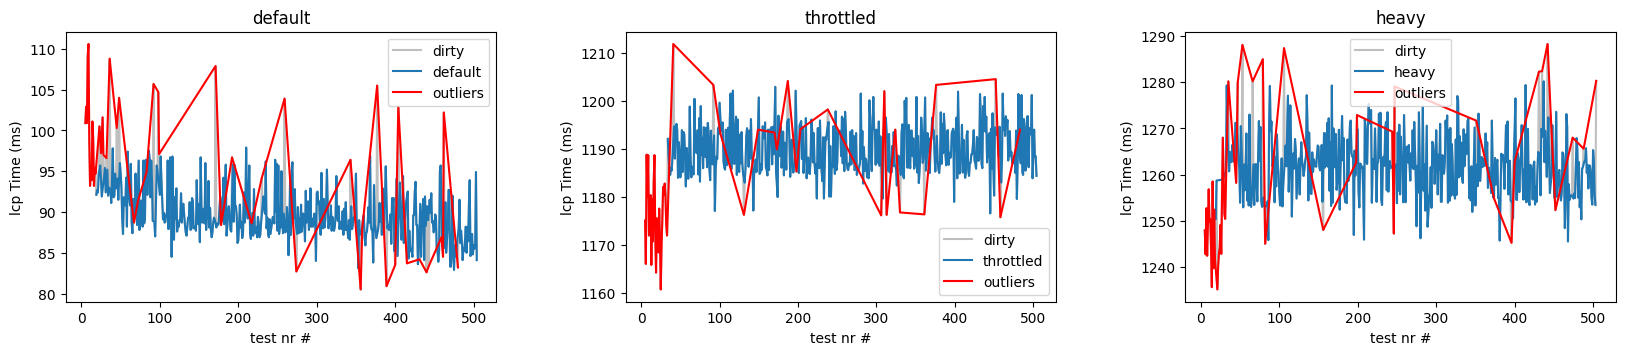

In [15]:
def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1

def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['lcp'], label='dirty', color='gray', alpha=0.5)
    loc.plot(_df['lcp'][mask[d]], label=d)
    loc.plot(_df['lcp'][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'lcp Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.legend()

masks = {}
dfs = {}
target_features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb']

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

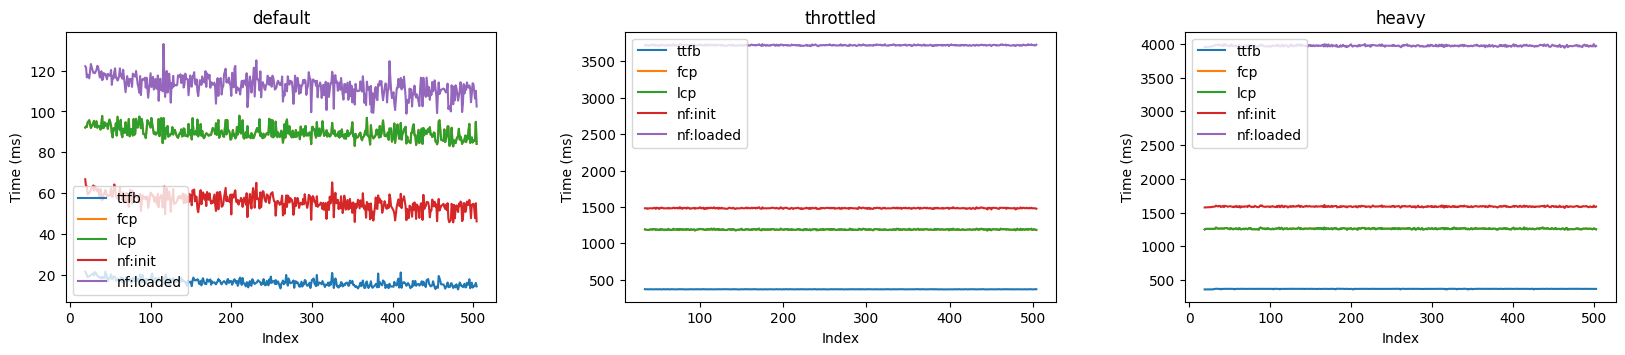

In [16]:
def plot_line(dataset, loc, idx):
    for t in ['ttfb', 'fcp', 'lcp', 'nf:init', 'nf:loaded']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

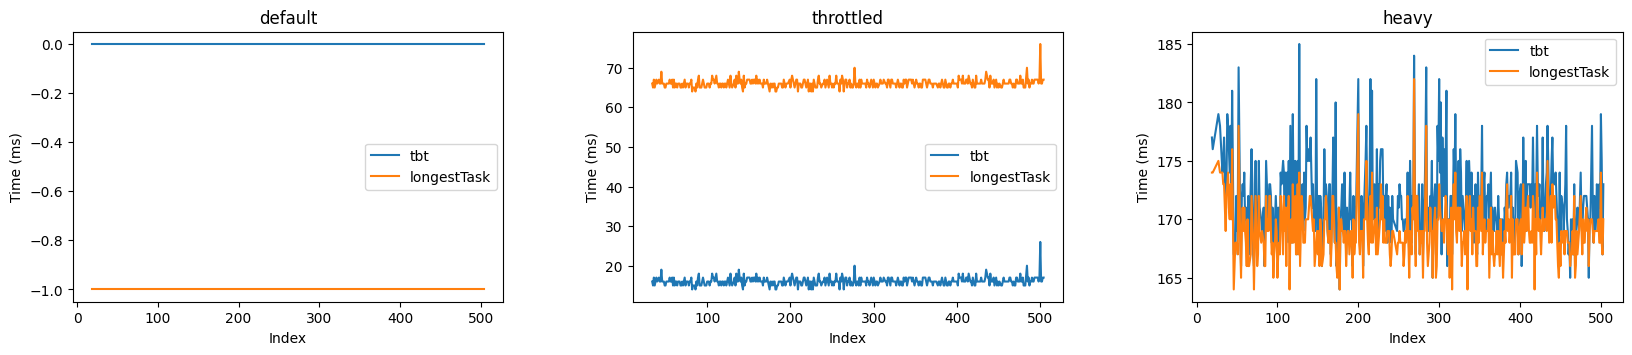

In [17]:
def plot_line(dataset, loc, idx):
    for t in ['tbt', 'longestTask']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

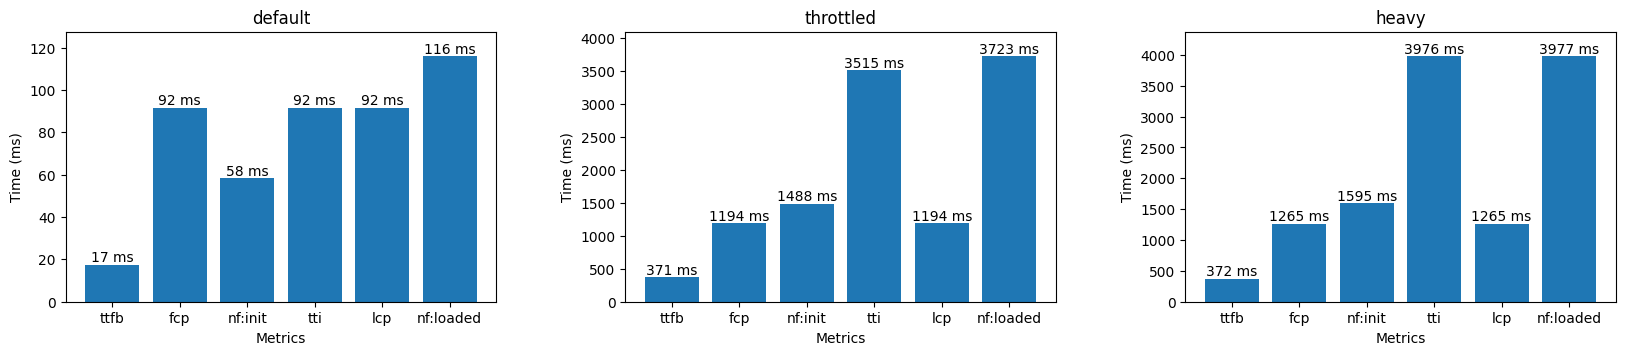

In [18]:
def plot_timeline_bars(dataset, loc, idx):
    metrics = ['ttfb', 'fcp', 'nf:init', 'tti', 'lcp', 'nf:loaded']
    quantiles = [dataset[t].quantile(0.75) for t in metrics]
    bars = loc.bar(metrics, quantiles, label='75th percentile')
    loc.set_xlabel('Metrics')
    loc.set_ylabel('Time (ms)')
    
    for bar in bars:
        height = bar.get_height()
        loc.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f} ms', ha='center', va='bottom')
    
    loc.set_ylim(0, max(quantiles) * 1.1)

graph_row(plot_timeline_bars, dfs)
plt.show()

In [19]:
dfs['default'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,264.50,21.41,111.74,89.71,89.71,16.36,0.00,89.71,0.00,-1.00,55.73,59.18,112.62,NaN
std,138.05,1.86,6.20,3.10,3.10,1.70,0.00,3.10,0.00,0.00,3.78,4.07,4.78,NaN
min,20.00,18.00,83.00,82.90,82.90,12.90,0.00,82.90,0.00,-1.00,45.70,48.60,98.90,NaN
25%,146.25,20.00,108.00,87.80,87.80,15.00,0.00,87.80,0.00,-1.00,53.52,56.90,110.10,NaN
50%,264.50,21.00,112.00,89.00,89.00,16.20,0.00,89.00,0.00,-1.00,55.90,59.20,112.95,NaN
75%,381.75,22.75,116.00,91.57,91.57,17.40,0.00,91.57,0.00,-1.00,58.37,61.90,115.90,NaN
max,505.00,28.00,125.00,97.90,97.90,21.60,0.00,97.90,0.00,-1.00,66.80,71.20,133.00,NaN


In [20]:
dfs['throttled'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,270.56,335.81,3516.11,1189.97,1189.97,369.79,16.09,3510.37,1.00,66.09,1482.76,1650.98,3719.97,NaN
std,136.61,1.02,6.27,4.99,4.99,1.00,1.04,6.22,0.00,1.04,5.33,5.78,5.47,NaN
min,35.00,333.00,3499.00,1176.60,1176.60,367.60,14.00,3493.50,1.00,64.00,1465.80,1636.50,3705.80,NaN
25%,152.25,335.00,3512.00,1186.10,1186.10,369.00,15.00,3506.83,1.00,65.00,1480.20,1645.20,3715.40,NaN
50%,270.50,336.00,3516.00,1188.50,1188.50,369.70,16.00,3510.10,1.00,66.00,1481.90,1651.20,3720.70,NaN
75%,389.75,337.00,3521.00,1193.90,1193.90,370.60,17.00,3515.20,1.00,67.00,1487.50,1653.20,3723.40,NaN
max,505.00,338.00,3534.00,1202.90,1202.90,371.90,26.00,3528.80,1.00,76.00,1496.70,1667.20,3736.80,NaN


In [21]:
dfs['heavy'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,266.82,344.99,3983.20,1261.85,1261.85,370.79,171.63,3969.91,3.00,169.08,1590.22,1769.87,3970.23,NaN
std,136.34,1.91,9.89,6.53,6.53,1.75,3.40,9.86,0.00,2.38,6.74,7.14,9.86,NaN
min,20.00,337.00,3953.00,1245.50,1245.50,362.40,164.00,3939.40,3.00,164.00,1568.30,1747.00,3940.10,NaN
25%,149.25,344.00,3976.00,1256.13,1256.13,370.33,169.00,3962.85,3.00,168.00,1584.70,1764.20,3963.10,NaN
50%,268.50,345.00,3983.00,1261.90,1261.90,371.15,171.00,3969.55,3.00,169.00,1590.25,1770.40,3969.85,NaN
75%,382.75,346.00,3989.00,1265.30,1265.30,371.80,173.00,3976.30,3.00,170.00,1594.85,1773.57,3976.80,NaN
max,504.00,348.00,4010.00,1280.20,1280.20,374.10,185.00,3996.20,3.00,182.00,1613.80,1793.10,3996.60,NaN


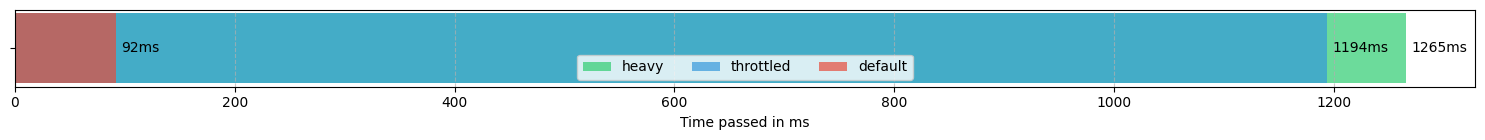

In [22]:
fig, ax = plt.subplots(figsize=(15, 1.5))

fcp_values = [df['fcp'].quantile(0.75) for df in dfs.values()]

bar_height = 0.25
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = []
for i, (name, value) in enumerate(zip(reversed(dfs.keys()), reversed(fcp_values))):
    bar = ax.barh(0.5, value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[-(i+1)]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

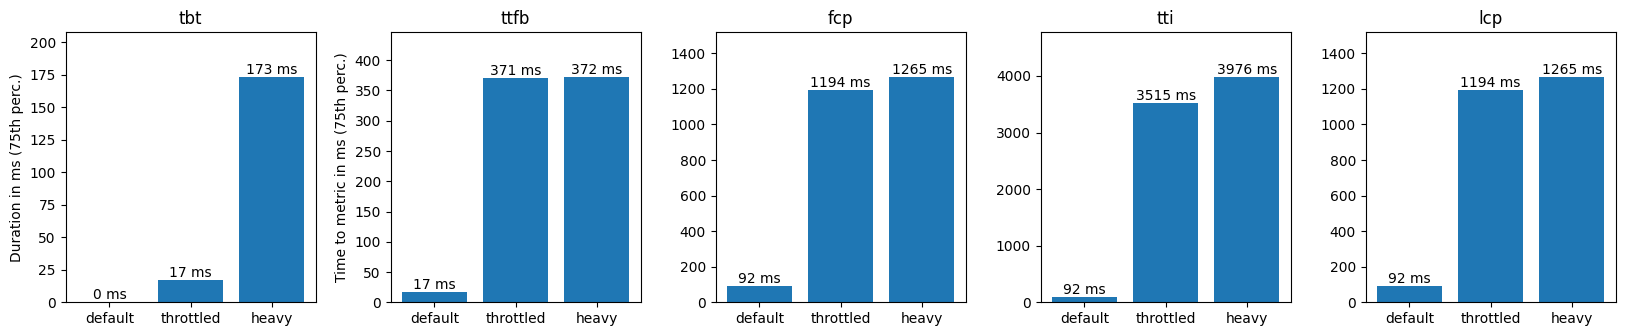

In [23]:
features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']
fig, axes = plt.subplots(ncols=len(features), figsize=(20, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

for idx, feature in enumerate(features):
    percentiles = {d: dfs[d][feature].quantile(0.75) for d in dfs.keys()}
    bars = axes[idx].bar(percentiles.keys(), percentiles.values())
    
    max_height = max(percentiles.values())
    axes[idx].set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        label = f'{int(round(height, 0))} ms'
        axes[idx].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
    
    axes[idx].set_title(feature)
    if idx == 0:
        axes[idx].set_ylabel('Duration in ms (75th perc.)')
    if idx == 1:
        axes[idx].set_ylabel('Time to metric in ms (75th perc.)')

plt.show()

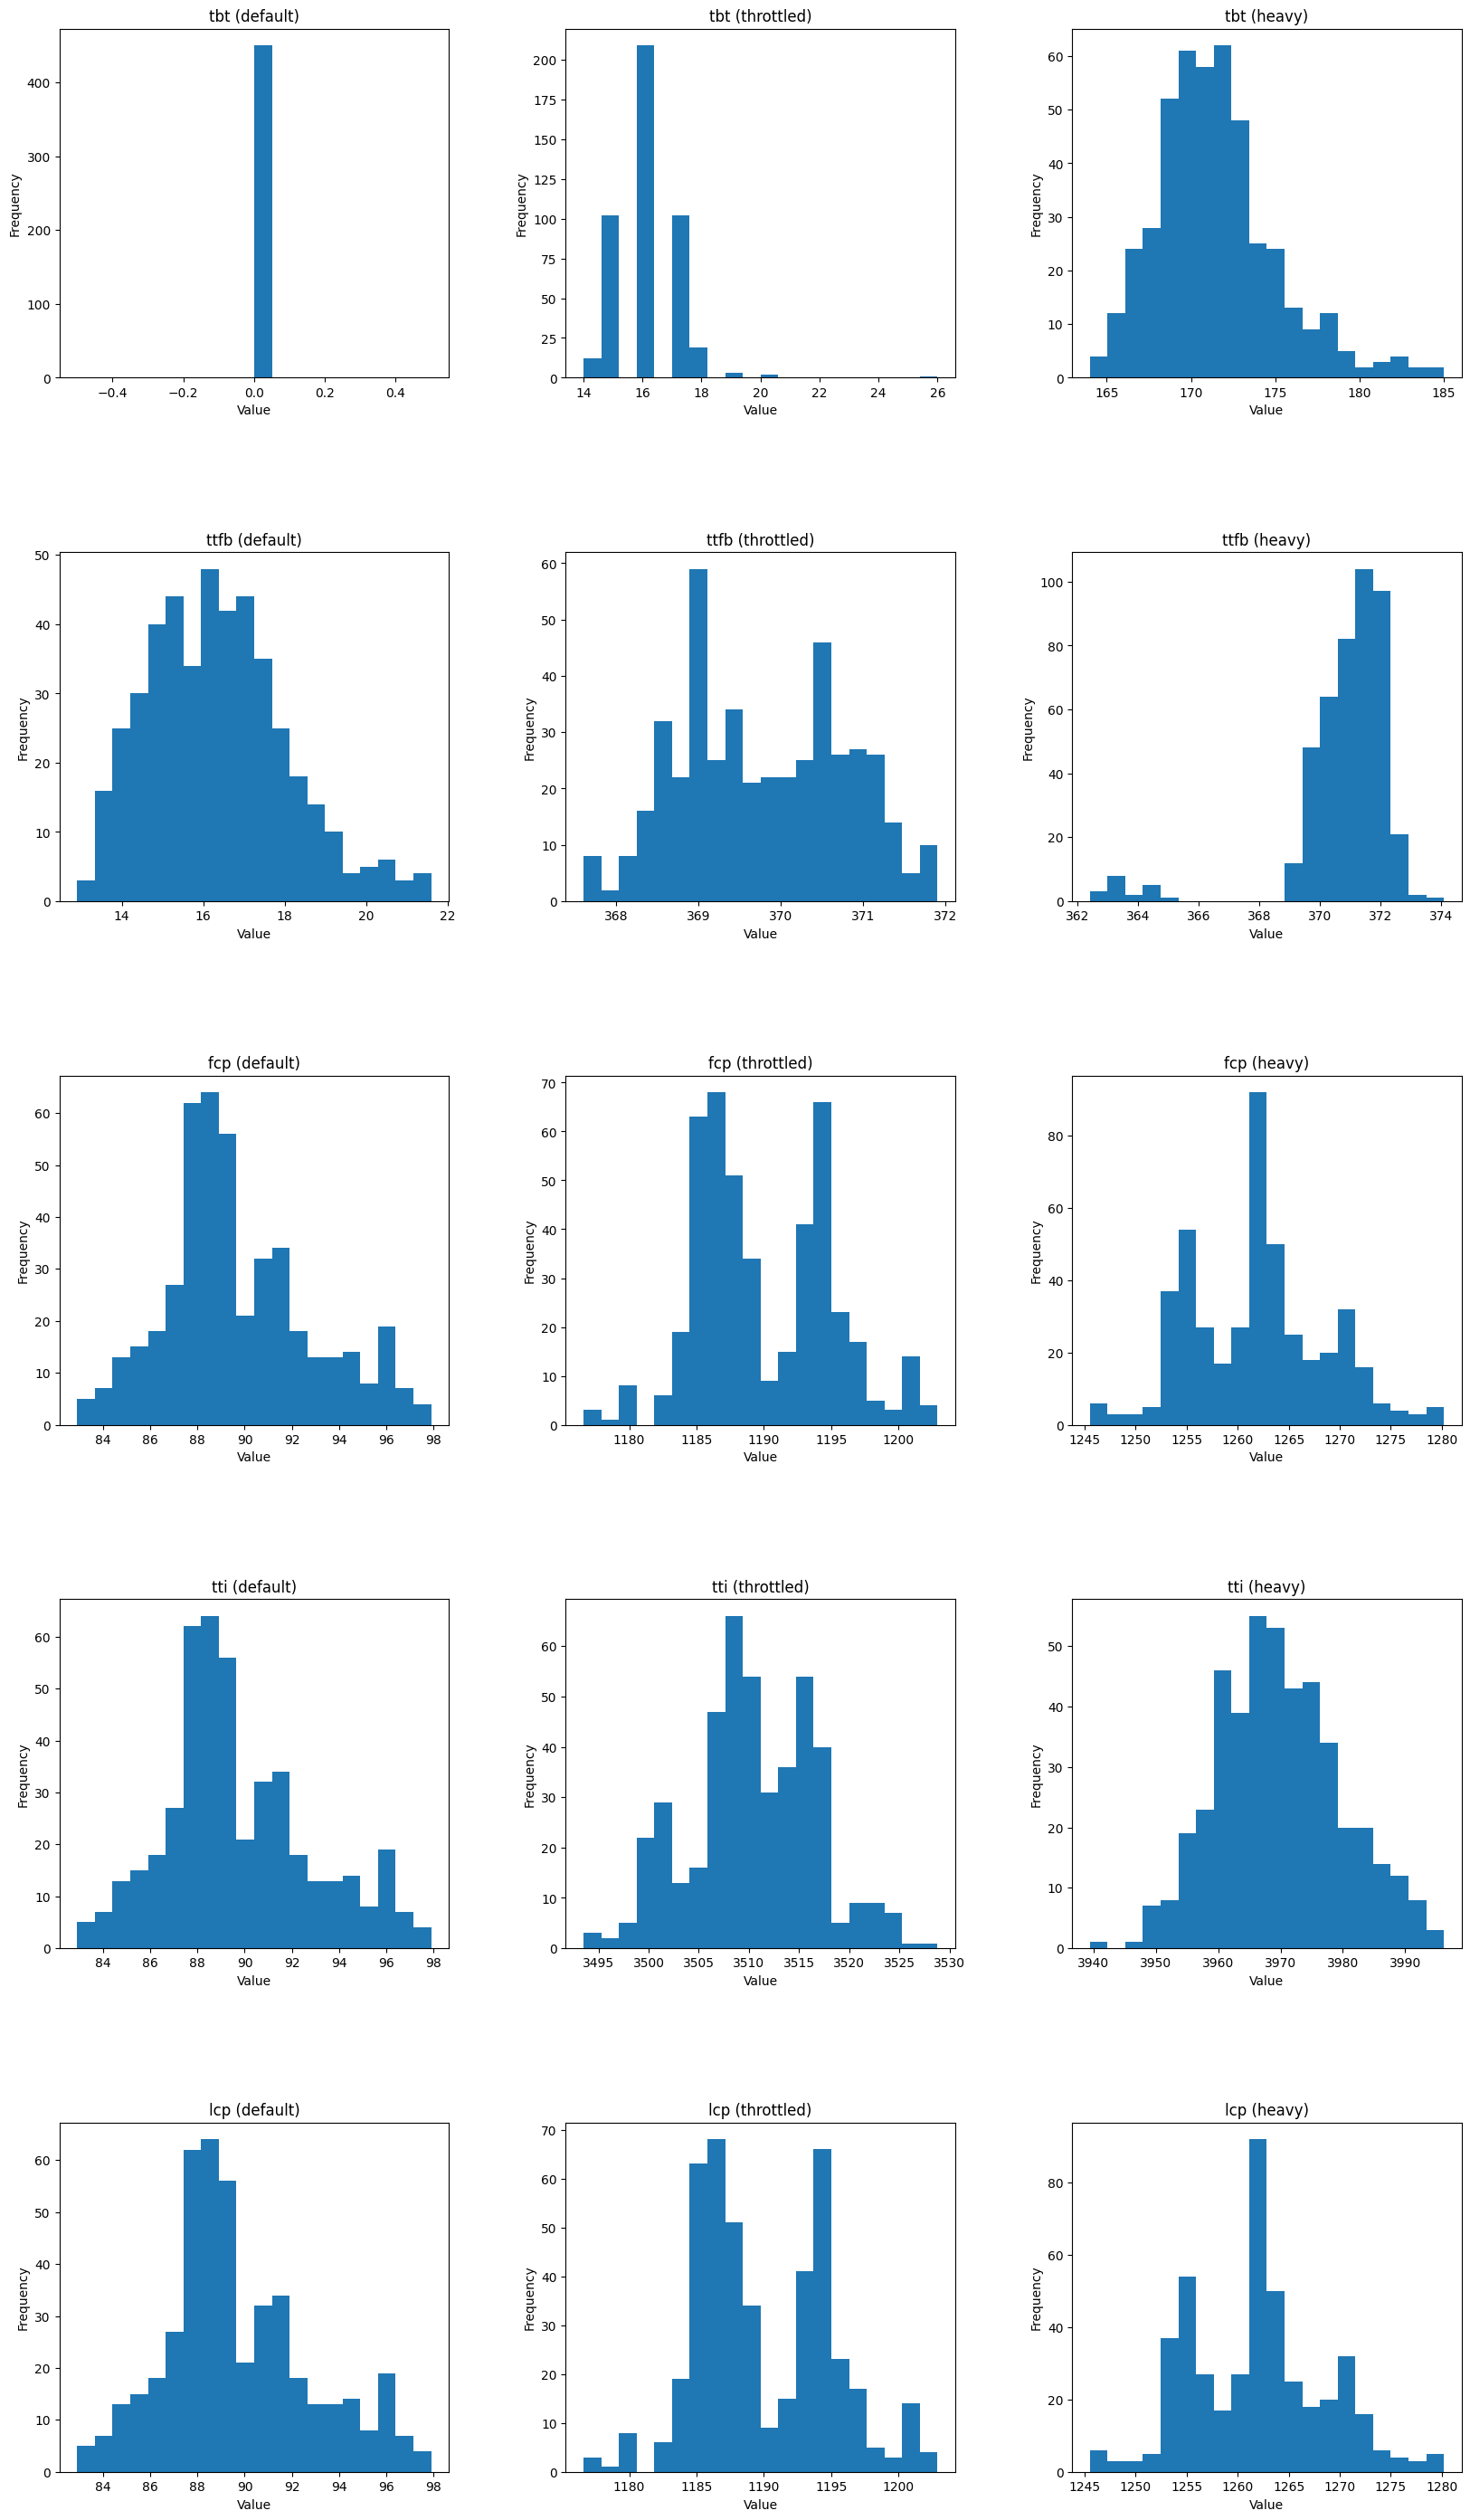

In [24]:
target_features = ['tbt', 'ttfb', 'fcp', 'tti', 'lcp']

fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        axes[y, x].hist(dfs[d][f], bins=20)
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_xlabel('Value')
        axes[y, x].set_ylabel('Frequency')

plt.show()

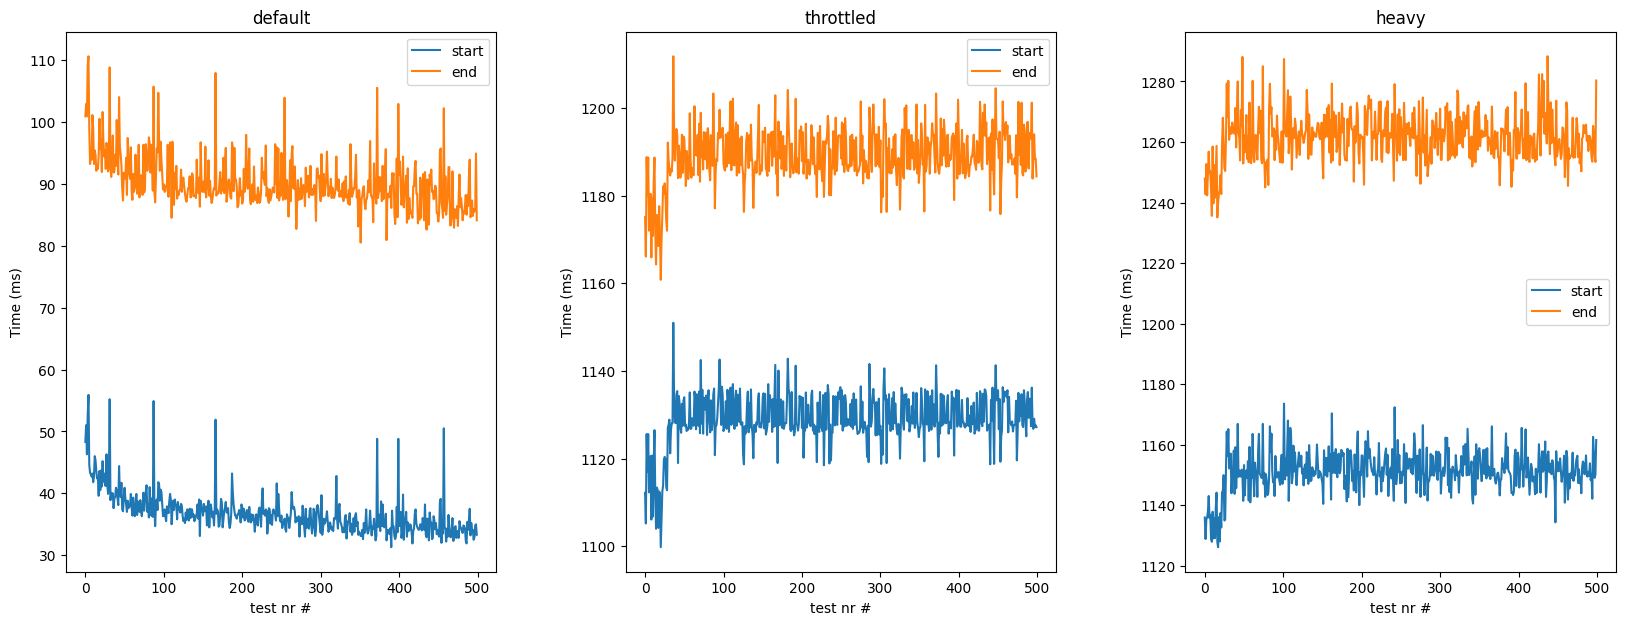

In [25]:
det_df = pd.read_csv(f'{path}details/2024-12-15T22:05:17.084Z_details-ssrh.csv', sep=',')
det_df_t = pd.read_csv(f'{path}details/2024-12-15T23:30:49.340Z_details-ssrh-throttled.csv', sep=',')
det_df_ht = pd.read_csv(f'{path}details/2024-12-16T07:53:32.353Z_details-ssrh-throttled-heavy.csv', sep=',')

lcp_dfs = {
  'default': det_df[(det_df['type'] == 'LCP') & (det_df['idx'] > 5)].reset_index(drop=True),
  'throttled': det_df_t[(det_df_t['type'] == 'LCP') & (det_df_t['idx'] > 5)].reset_index(drop=True),
  'heavy': det_df_ht[(det_df_ht['type'] == 'LCP') & (det_df_ht['idx'] > 5)].reset_index(drop=True),
}
lcp_features = ['start','end','duration','name','element','url','id']


def plot_lcp_line(_df, loc, idx):
  for f in ['start', 'end']:
    loc.plot(_df[f], label=f)
  
  loc.set_title("LCP")
  loc.set_ylabel('Time (ms)')
  loc.set_xlabel('test nr #')
  loc.legend()

graph_row(plot_lcp_line, lcp_dfs, height=6)
plt.show()